<a href="https://colab.research.google.com/github/isabelgaron/album_artwork_translation/blob/master/Head_direction_cells_BasisGPLVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import jax.numpy as jnp
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt
import jax

import numpy as np
import pandas as pd
!pip install pynapple
import pynapple as nap
import scipy.ndimage
import requests, math, os
import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.0/134.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.5/331.5 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 25.8 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=1c4ee69e088c643514cbfafd163ba2521d0471c62fbd65a6be12cae1c95e5d6a
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [3]:
def basis_func_lattice(max_freq, latent_dim):
    lattice = jnp.meshgrid(*[jnp.arange(max_freq) for _ in range(latent_dim)])
    return jnp.column_stack([z.ravel() for z in lattice]).astype(float)[1:]

def phi(x, lattice):
    """
    Parameters
    ----------
    x : array
        (samples x latent_dim) - QMC test points.

    lattice : array
        Basis function coefficients (num_bases // 2)

    Returns
    -------
    phi : array
        (samples x num_bases)
    """
    z = x @ lattice.T
    return jnp.column_stack((
        jnp.sin(2 * jnp.pi * z),
        jnp.cos(2 * jnp.pi * z))
    )


def logprob_yt_given_W(W0, W, y, x, phi_lattice, noise_scale):
    """
    Parameters
    ----------
    W0 : array
        (num_neurons) - Intercept term

    W : array
        (num_bases x num_neurons) - Basis function coefficients

    y : array
        (num_neurons,) - Observed data at a single timepoint / sample

    x : array
        (mc_samples x latent_dim) - QMC test points.

    lattice : array
        Lattice of basis function parameters to

    noise_scale : float
        Scale of measurement noise

    Returns
    -------
    log_prob : float
    """
    # shape == (mc_samples x num_neurons)
    F = phi(x, phi_lattice) @ W + W0[None, :]

    # shape == (mc_samples x num_neurons)
    lps = jax.scipy.stats.norm.logpdf(
        y[None, :], loc=F, scale=noise_scale
    )

    # sum over neurons, then log-sum-exp over MC samples.
    return jax.scipy.special.logsumexp(jnp.sum(lps, axis=-1))


def logprob_Y_given_W(W0, W, Y, X, phi_lattice, noise_scale):
    # qmc estimation of integral p(y|w)
    # X: (mc_samples x latent_dim)
    res = 0
    for t in range(Y.shape[0]):
      res = res + logprob_yt_given_W(W0, W, Y[t], X, phi_lattice, noise_scale)
    return res

'''logprob_Y_given_W = jax.vmap(
    logprob_yt_given_W, (None, None, 0, 0, None, None), 0
)'''

def logprob_W(W, taus):
    """
    Parameters
    ----------
    W : (num_bases x num_neurons) array
        Basis function coefficients

    taus : (num_bases) array
        Prior variance for basis function coefficient

    Returns
    -------
    logprob : float # if not sum, 2x31 (sin/cosxneurons)
    """
    lps = jax.scipy.stats.norm.logpdf(
        W, loc=0.0, scale=taus[:, None]
    )
    return jnp.sum(lps)


def joint_prob(W0, W,Y, X, phi_lattice, noise_scale, taus):
    return (
        logprob_W(W, taus) +
        logprob_Y_given_W(W0, W, Y, X, phi_lattice, noise_scale)
    )


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Load data
####- will need to give permission to save a file in **drive**

In [4]:
path = "Mouse32-140822.nwb"
if path not in os.listdir("."):
    r = requests.get(f"https://osf.io/jb2gd/download", stream=True)
    block_size = 1024*1024
    with open(path, 'wb') as f:
        for data in tqdm.tqdm(r.iter_content(block_size), unit='MB', unit_scale=True,
            total=math.ceil(int(r.headers.get('content-length', 0))//block_size)):
            f.write(data)
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
35.0MB [00:00, 54.4MB/s]                          
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


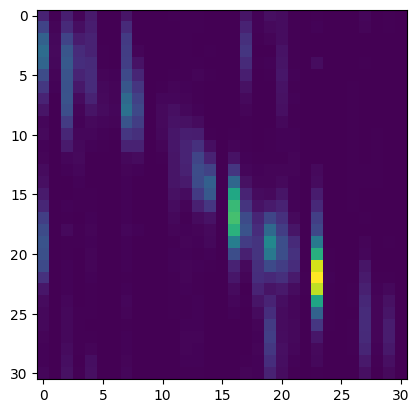

In [52]:

data = nap.load_file("/content/Mouse32-140822.nwb")

spikes = data["units"]  # Get spike timings
epochs = data["epochs"]  # Get the behavioural epochs (in this case, sleep and wakefulness)
angle = data["ry"]  # Get the tracked orientation of the animal

spikes_adn = spikes.getby_category("location")["adn"]  # Select only those units that are in ADn

tuning_curves = nap.compute_1d_tuning_curves(
                    group=spikes_adn,
                    feature=angle,
                    nb_bins=31,
                    ep = epochs['wake'],
                    minmax=(0, 2 * jnp.pi)
                    )
pref_ang = tuning_curves.idxmax()
pref_ang_sorted = jnp.argsort(np.array(pref_ang))
pref_ang = jnp.array(pref_ang)[pref_ang_sorted]
tuning_curves = jnp.array(tuning_curves)[:,pref_ang_sorted]

plt.figure()
plt.imshow(tuning_curves)
binned = spikes_adn.count(.2, ep=epochs['wake']) # bin 200ms

# training data
Y = np.sqrt(jnp.array(binned[9020:9045])[:,pref_ang_sorted]) # sort neurons by preferred angle
Y = Y# - jnp.mean(Y, axis=0)

angle = jnp.mean(jnp.array(angle[9020:9045.6]).reshape(125,8), axis=1)#average head direction over binned window


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
100%|██████████| 30/30 [01:22<00:00,  2.74s/it]


Text(0, 0.5, 'Log Probability')

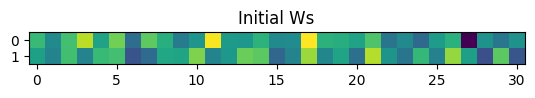

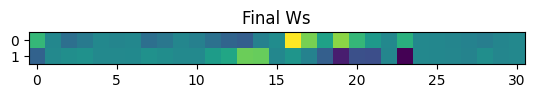

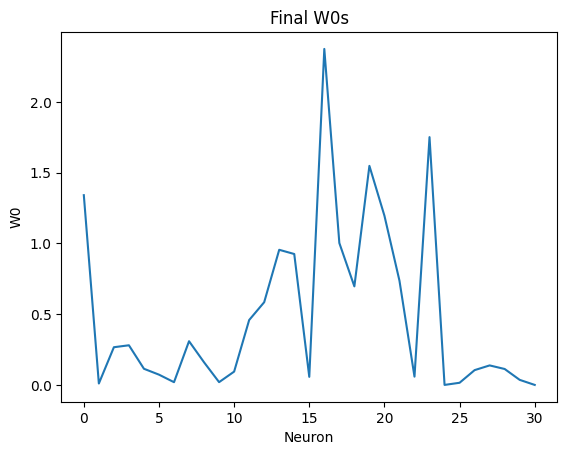

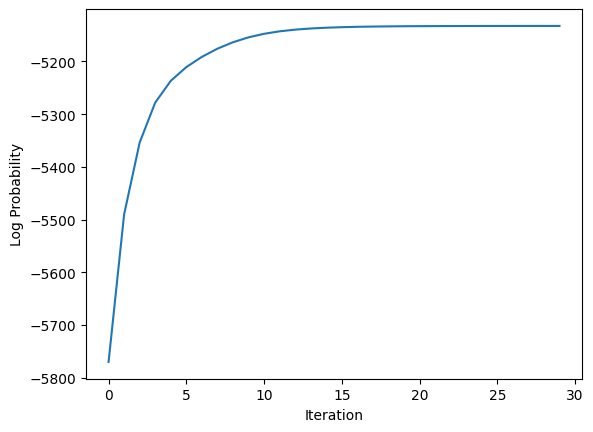

In [53]:
# Fit model
MAX_FREQ = 2
LATENT_DIM = 1
NUM_NEURONS = 31
NUM_SAMPLES = 125
noise_scale =1.5
mc_samples = 30

phi_lattice = basis_func_lattice(MAX_FREQ, LATENT_DIM)

taus = jnp.concatenate(
    (jnp.exp(-jnp.sum(phi_lattice, axis=1) / 5),
     jnp.exp(-jnp.sum(phi_lattice, axis=1) / 5))
)

NUM_BASES = len(taus)


objective = jax.value_and_grad(joint_prob, argnums=(0,1))

# Randomly initialize x
qrng = Sobol(d=LATENT_DIM)
X = qrng.random(n=mc_samples)

# Randomly initialize w
W = jax.random.normal(
    jax.random.PRNGKey(1), shape=(NUM_BASES, NUM_NEURONS)
) * taus[:, None]

W0 = jnp.mean(Y, axis=0)#jnp.ones((NUM_NEURONS))
learning_rate = 1e-2
log_probs = []

plt.figure()
plt.title("Initial Ws")
plt.imshow(W)
for i in tqdm.trange(30):

    # Compute current objective function and gradient.
    w, g = objective(W0, W, Y, X, phi_lattice, noise_scale, taus)

    # Save optimization progress.
    log_probs.append(w)
    W0 = W0 + learning_rate * g[0]
    W = W + learning_rate * g[1]

# Optimization Plotting
plt.figure()
plt.title("Final Ws")
plt.imshow(W)
plt.figure()
plt.title("Final W0s")
plt.plot(W0)
plt.xlabel("Neuron")
plt.ylabel("W0")
plt.figure()
plt.plot(log_probs)
plt.xlabel("Iteration")
plt.ylabel("Log Probability")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(125, 31)


<ipython-input-56-f7d3f9067008>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2,1)


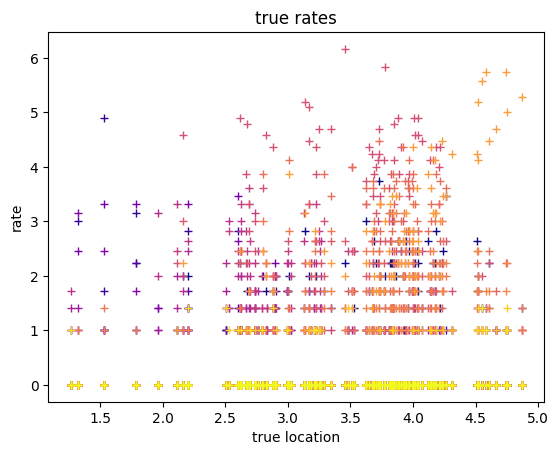

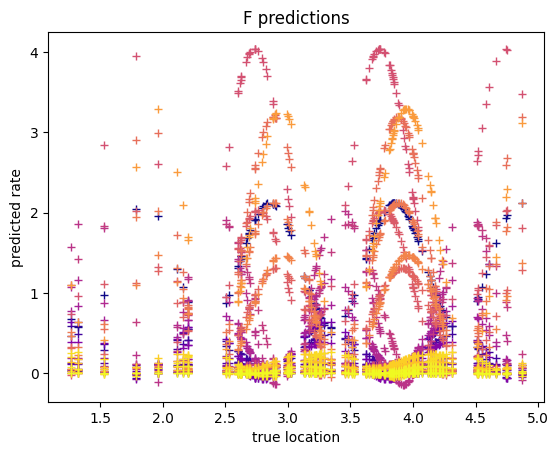

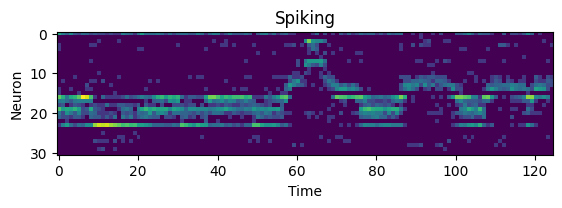

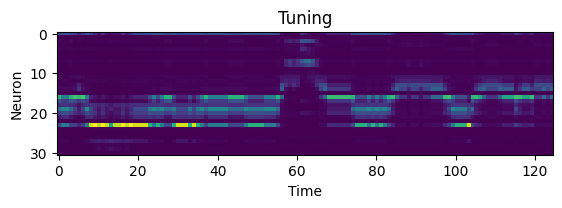

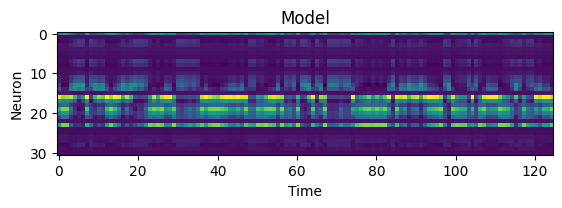

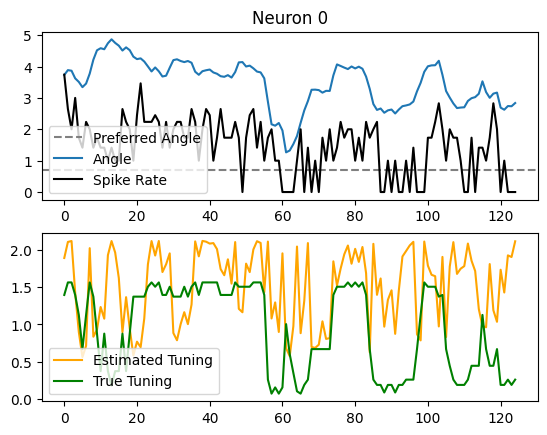

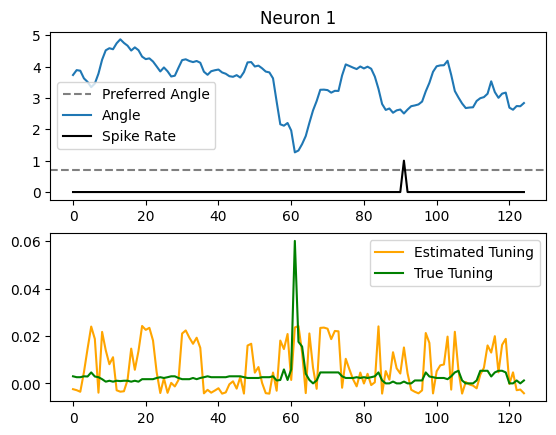

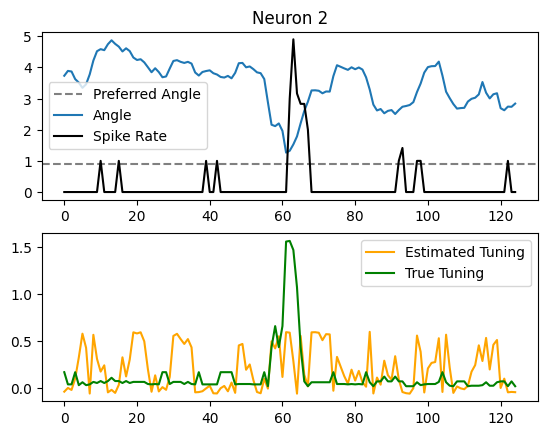

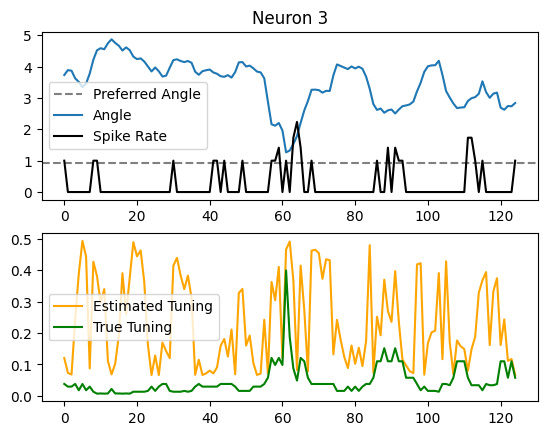

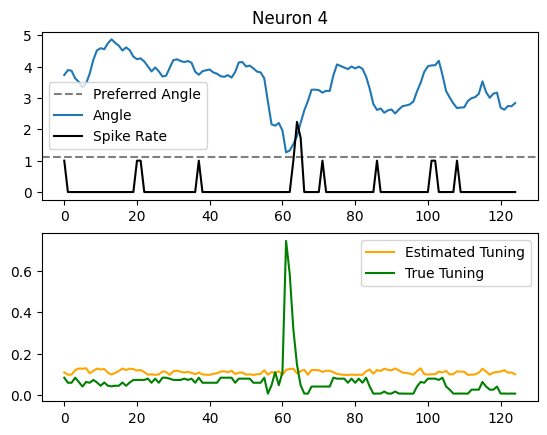

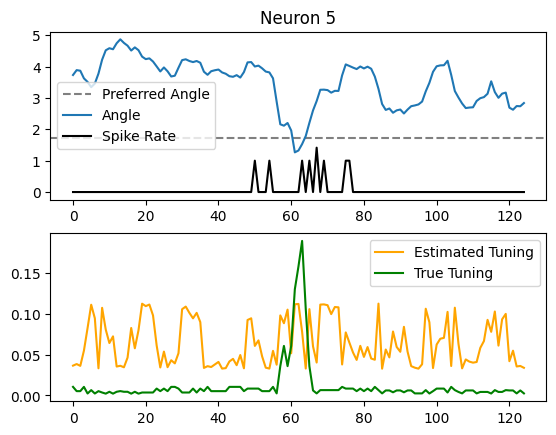

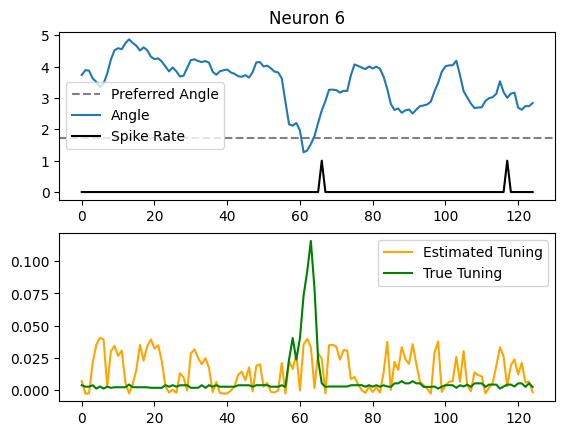

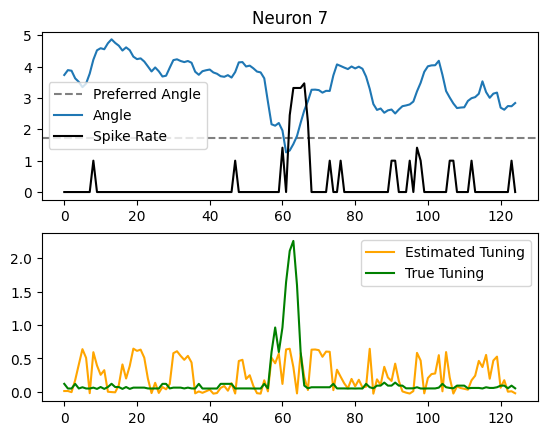

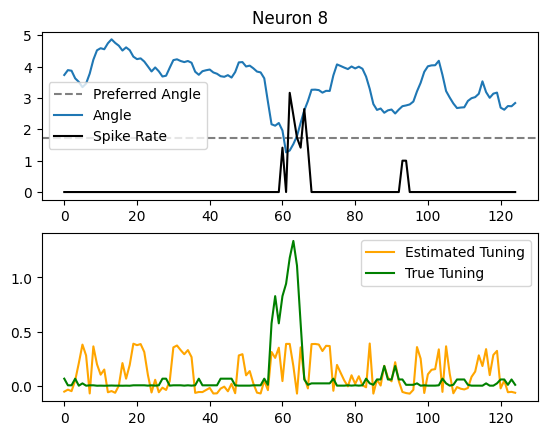

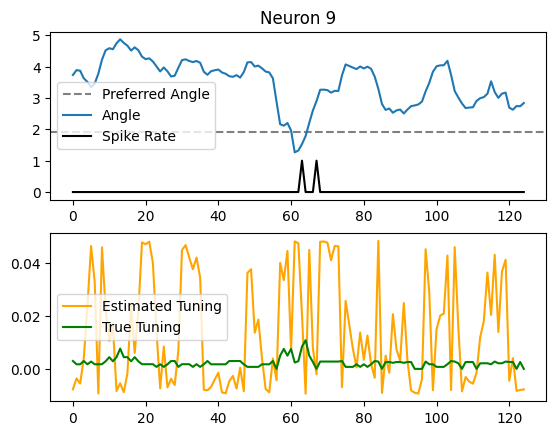

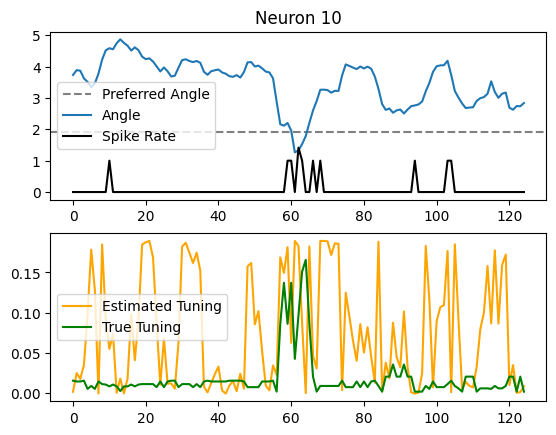

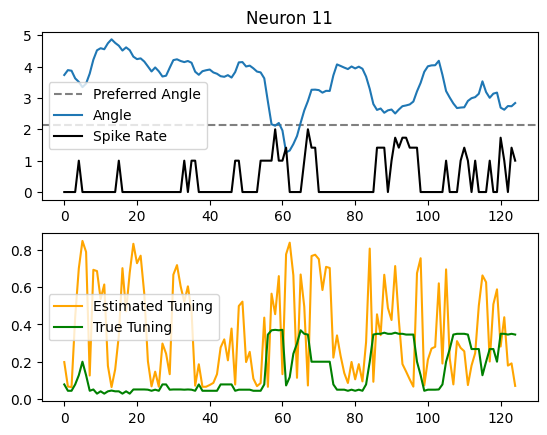

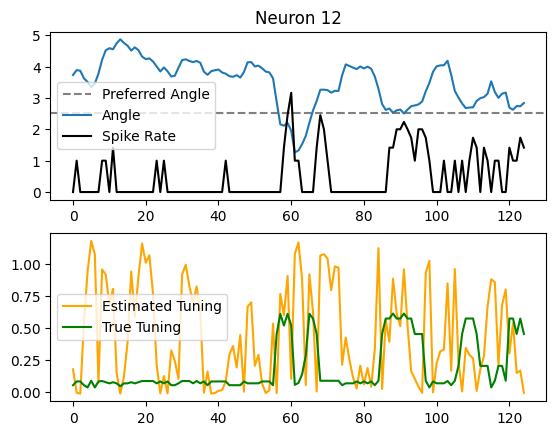

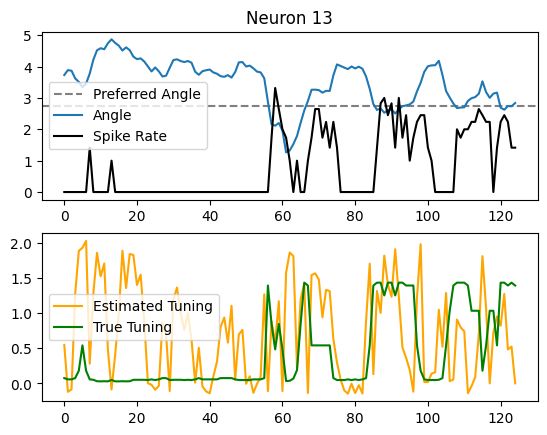

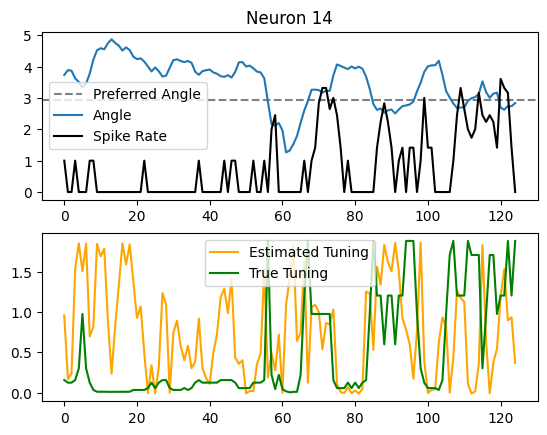

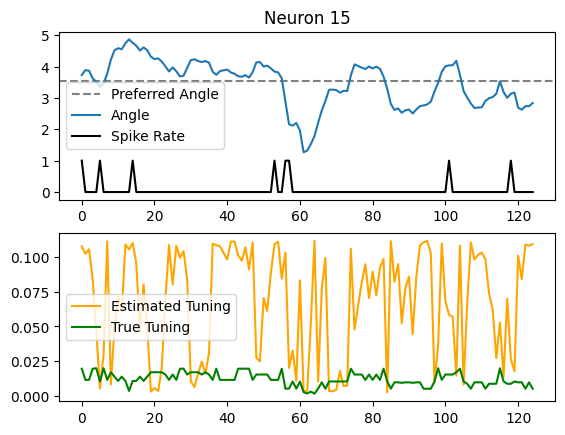

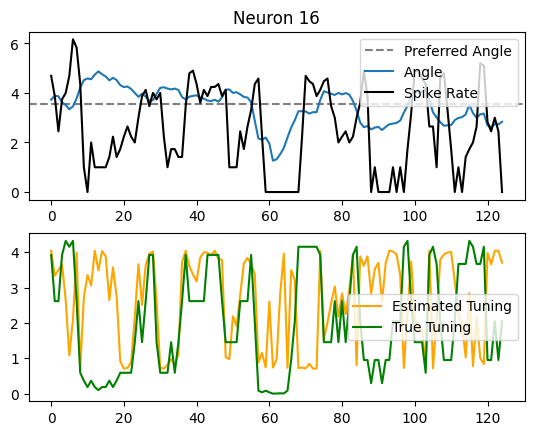

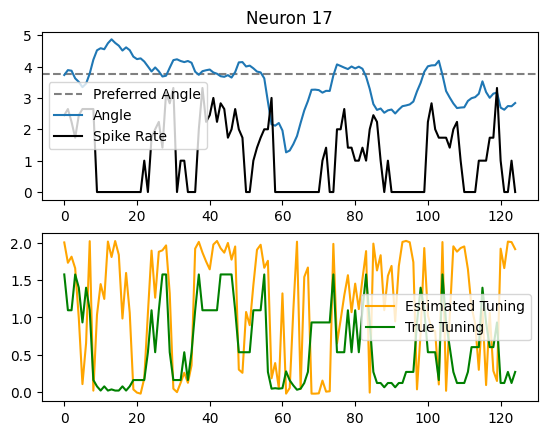

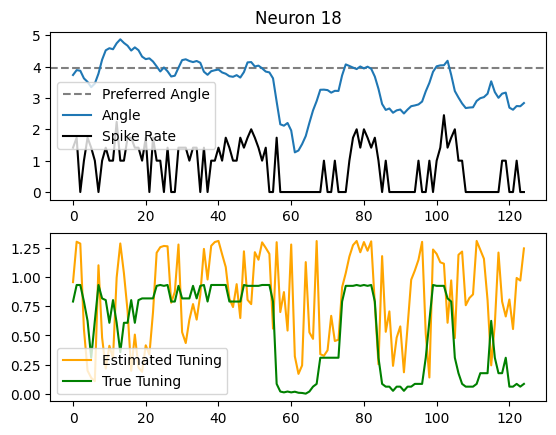

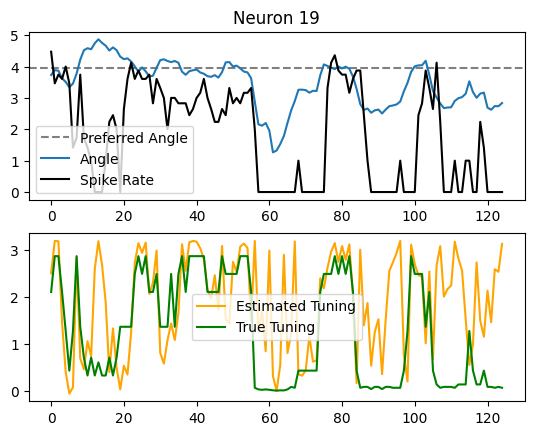

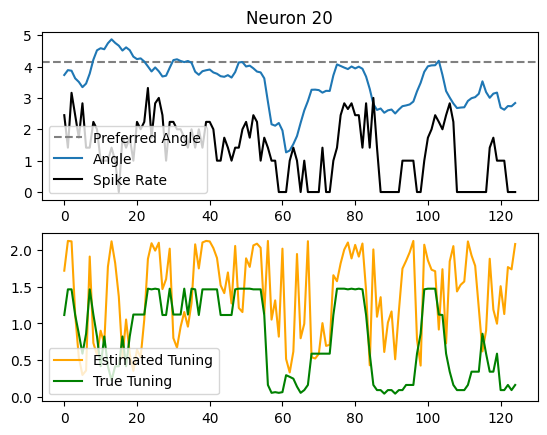

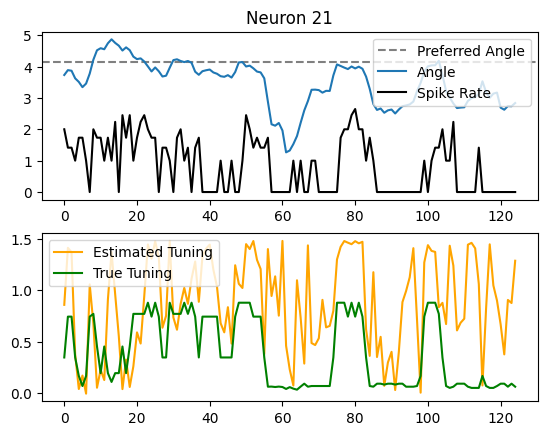

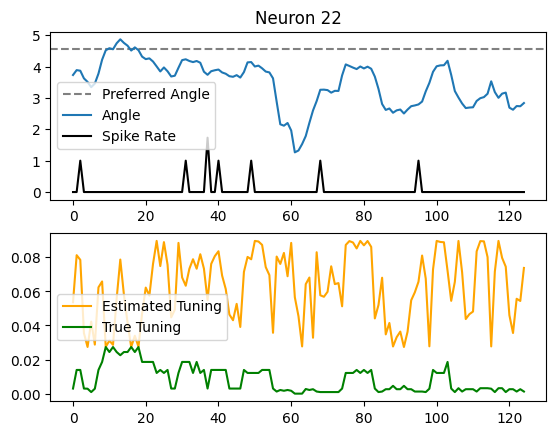

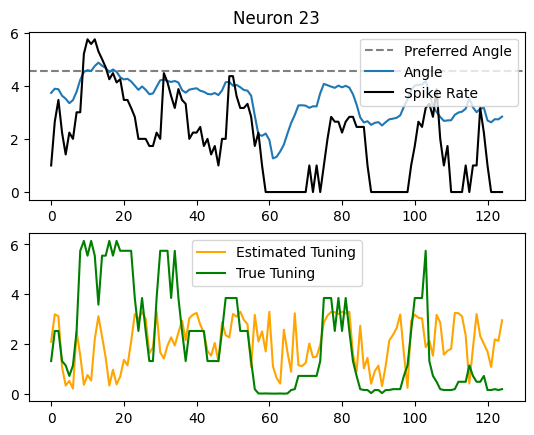

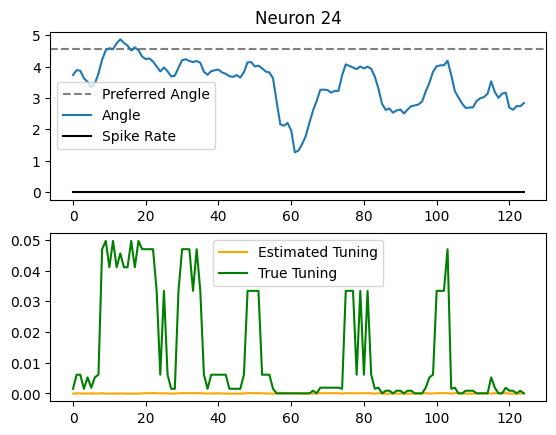

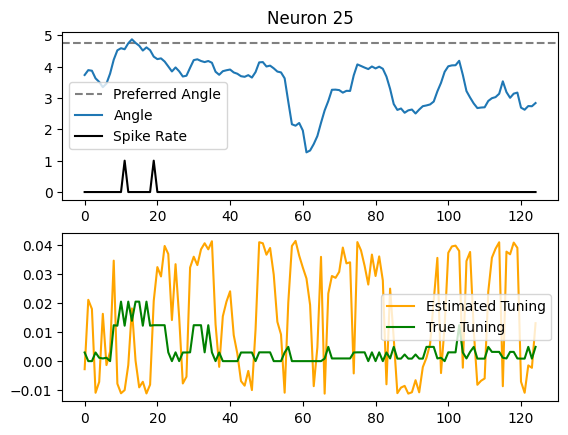

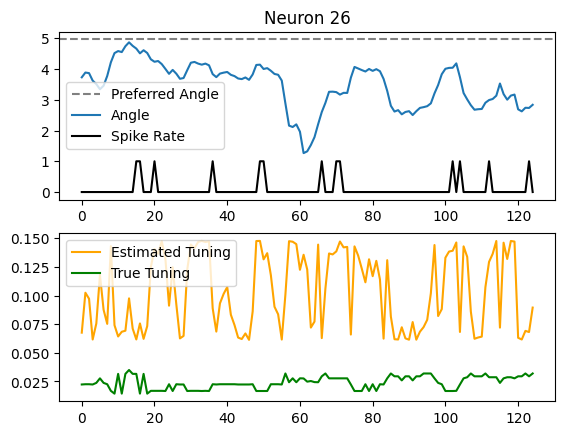

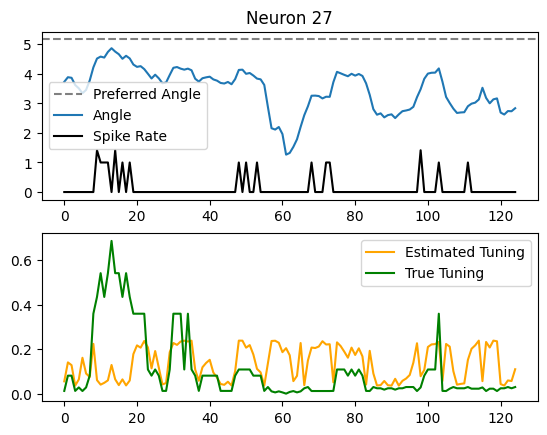

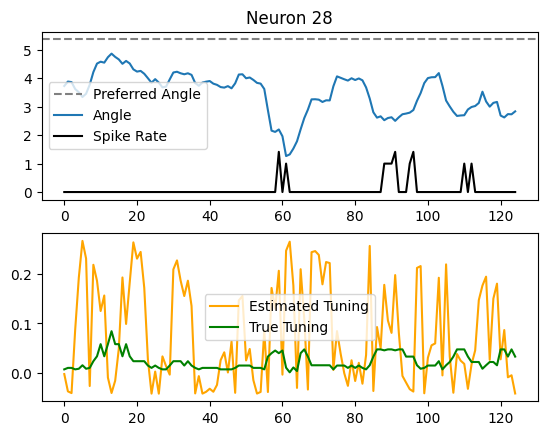

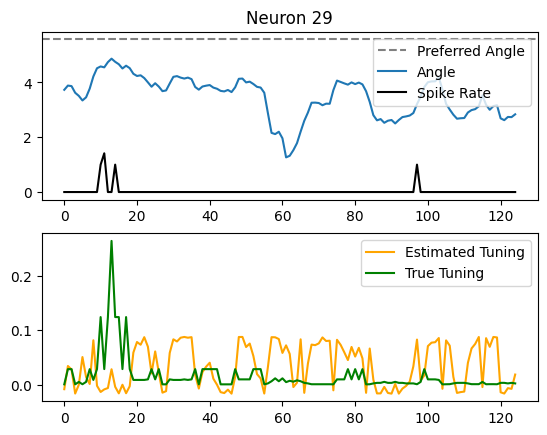

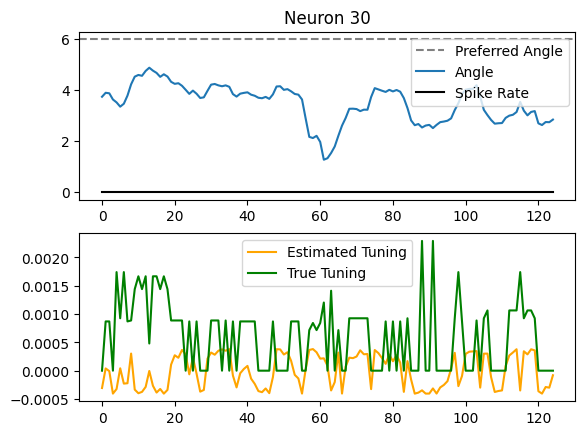

In [56]:

col = plt.cm.plasma(np.linspace(0,1,NUM_NEURONS))

plt.figure()
for i in range(NUM_NEURONS):
  plt.plot(angle, Y[:,i], '+', color=col[i])
plt.title('true rates')
plt.xlabel('true location')
plt.ylabel('rate')

plt.figure()
plt.title('F predictions')
result = -1*phi(jnp.reshape(angle, (NUM_SAMPLES,LATENT_DIM)), phi_lattice) @ W + W0
print(result.shape)
for i in range(NUM_NEURONS):
  plt.plot(angle, result[:,i], '+', color=col[i])
plt.xlabel('true location')
plt.ylabel('predicted rate')

plt.figure()
plt.title("Spiking")
plt.imshow(Y.T)
plt.ylabel("Neuron")
plt.xlabel ("Time")

bin_angle = np.rint((angle/(2*jnp.pi))*31)
tuning_curves = jnp.array(tuning_curves)
temp_tuning_curves = np.zeros((NUM_NEURONS, NUM_SAMPLES))

for j in range(NUM_SAMPLES):
  temp_tuning_curves[:,j] = tuning_curves[int(bin_angle[j]),:]

plt.figure()
plt.title("Tuning")
plt.imshow(temp_tuning_curves)
plt.ylabel("Neuron")
plt.xlabel ("Time")
plt.figure()
plt.title("Model")
plt.imshow(result.T)
plt.ylabel("Neuron")
plt.xlabel ("Time")

for i in range(0,NUM_NEURONS):
  fig, axs = plt.subplots(2,1)
  axs[0].set_title("Neuron "+str(i))
  axs[0].axhline(pref_ang[i], linestyle='--', color = "grey", label = "Preferred Angle")
  axs[0].plot(angle, label="Angle")
  axs[0].plot(Y[:,i], color="black", label = "Spike Rate")
  axs[0].legend()
  axs[1].plot(result[:, i], color="orange", label = "Estimated Tuning")

  #not sure what the units are on these tuning curves
  axs[1].plot(temp_tuning_curves[i,:]/ 20, label="True Tuning", color= "green")

  axs[1].legend()

